### This notebook contains Prophet, LightGBM, ARIMA, and EWA methods of M5 timeseries forecast 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_percentage_error
import time

In [2]:
# Download the CSV file
df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
#All category items are grouped together to create a target variable

df.drop(columns=['item_id', 'dept_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['cat_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='cat_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_cat = data.groupby(level=0, axis=1).sum()

#All department items are grouped together to create a target variable

df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'cat_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['dept_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='dept_id',inplace=True) 
data.columns.name = None 

calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_dept = data.groupby(level=0, axis=1).sum()

#State-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','store_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['state_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='state_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_state = data.groupby(level=0, axis=1).sum()

#Store-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','state_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['store_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='store_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_store = data.groupby(level=0, axis=1).sum()
#Concat all dataframes
df = pd.concat([df_cat,df_dept,df_state,df_store, ], axis=1)

df['ds'] = df.index.values
# Convert the 'ds' column to datetime type
df['ds'] = pd.to_datetime(df['ds'])
df.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,ds
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,3494,4739,1625,2556,3852,3030,2704,2256,4038,2011-01-29


### PROPHET MODEL

In [3]:
df_prophet = df.copy()

In [4]:
# Split the data into train and test sets

train_size = int(len(df_prophet) * 0.8)  # 80% for training
train, test = df_prophet[:train_size], df_prophet[train_size+1:]

In [5]:
#Create train and test dataframes for Prophet:
# train data has 2011-01-29 to 2015-04-07 (1530 rows) and test data has 2015-04-09 to 2016-04-24 (382 rows)
train_prophet = train.copy()
test_prophet = test.copy()
len(train_prophet),len(test_prophet)

(1530, 382)

In [6]:
target_columns = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
                  'HOUSEHOLD_2','CA','TX','WI','CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']

In [7]:
#Prophet model with holidays

holidays = calendar[calendar['event_type_1'].isnull() == False]
holidays = holidays[['date','event_name_1', 'event_type_1']]
holidays.rename(columns={'date':'ds','event_name_1':'holiday'},inplace=True)

In [8]:
# Start measuring execution time
start_time = time.time()
models = {}

# Iterate over target columns
for column in target_columns:
    # Rename the columns to 'ds' and 'y'
    train_target = train_prophet[[column]].rename(columns={column: 'y'})
    train_target['ds'] = train_prophet.index
    
    model = Prophet(weekly_seasonality=True, holidays=holidays)
    model.fit(train_target)
    models[column] = model

# Calculate the execution time
execution_time = time.time() - start_time
execution_time

13:12:03 - cmdstanpy - INFO - Chain [1] start processing
13:12:03 - cmdstanpy - INFO - Chain [1] done processing
13:12:03 - cmdstanpy - INFO - Chain [1] start processing
13:12:03 - cmdstanpy - INFO - Chain [1] done processing
13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing
13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing
13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing
13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing
13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing
13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing
13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1]

9.051079511642456

In [9]:
# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = models[column]
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test))
    
    # Rename the columns to 'ds'
    future = future.rename(columns={'ds': 'ds'})
    
    # Make predictions
    #The .tail(len(test))` part ensures that only the predictions for the test set are stored.
    forecast = model.predict(future)
    predictions[column] = forecast['yhat'].tail(len(test))

In [10]:
# Save predictions as predictions_prophet
predictions_prophet = predictions

# Print the values in predictions_prophet
for column, values in predictions_prophet.items():
    print(f"Predictions for {column}:")
    print(values)
    print()

Predictions for FOODS:
1530    21074.088280
1531    21165.591653
1532    23481.198484
1533    27412.350265
1534    27525.461058
            ...     
1907    19552.830867
1908    19199.858310
1909    19260.702342
1910    21552.431362
1911    26202.633758
Name: yhat, Length: 382, dtype: float64

Predictions for HOBBIES:
1530    3484.601887
1531    3523.271783
1532    3932.984138
1533    4715.141598
1534    3969.125216
           ...     
1907    3996.448235
1908    4001.578155
1909    4031.499113
1910    4433.560451
1911    5004.985772
Name: yhat, Length: 382, dtype: float64

Predictions for HOUSEHOLD:
1530     7876.436633
1531     7955.424689
1532     9025.088080
1533    10948.141079
1534     9890.238917
            ...     
1907     8941.749347
1908     8853.608270
1909     8929.737766
1910     9996.074575
1911    11746.538691
Name: yhat, Length: 382, dtype: float64

Predictions for FOODS_1:
1530    2699.896442
1531    2738.312241
1532    3013.627629
1533    3231.977243
1534    3252.75

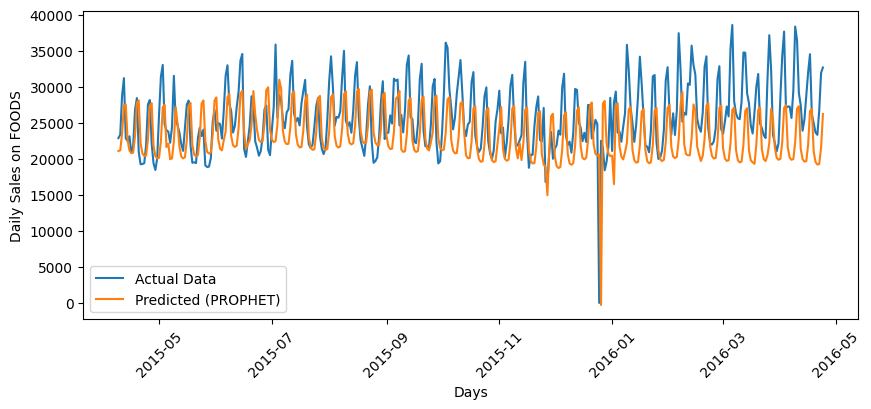

In [54]:
# Plot the predictions
# Convert the index to a DatetimeIndex

test.index = pd.to_datetime(test.index)

plt.figure(figsize=(10, 4))
plt.plot(test.index, test['FOODS'], label='Actual Data')
plt.plot(test.index, predictions_prophet['FOODS'], label='Predicted (PROPHET)')
plt.xlabel('Days')
plt.ylabel('Daily Sales on FOODS')
#plt.title('PROPHET FIT')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [12]:
mape_prophet = []
rmse_prophet = []

for column in target_columns:
    actual = test[column].values.astype('float64')
    predicted = predictions[column].values
    mape = mean_absolute_percentage_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape_prophet.append(mape)
    rmse_prophet.append(rmse)

print("All RMSE values:", rmse_prophet)
print("All MAPE values:", mape_prophet)

All RMSE values: [5301.623329719902, 597.4043395495909, 1633.8766240582363, 608.0407142987697, 1188.3787984445187, 4000.841626437104, 562.1306982570026, 161.21043116892037, 1336.4195793128986, 323.5977981894443, 3459.4404039642304, 1790.5406370880542, 2526.2609502754617, 824.9772115486344, 2091.3778069266905, 969.4602774964568, 327.46010935947385, 569.8731930316046, 723.8847384406837, 585.7749971912388, 729.6913761833301, 1053.577187093273, 1086.7709855259027]
All MAPE values: [4.2924385926396615, 4.3668410261305784e+16, 20.811984825352617, 8.016773481374887, 4.864900488117681e+16, 3.057471387046034, 3.710896775023157e+16, 6150141164100668.0, 7.421872919005626e+16, 4.331195138915735, 5.649445254110273, 6.1533256942561145, 6.47695216426565, 4.5481428789541704e+16, 2.425962623395828, 3.493233994656482, 2.3840233321259836e+16, 7.472485534277767, 3.70919010331124e+16, 3.0198442640152927, 4.896939838162112, 10.061242287010963, 6.507056662836419]


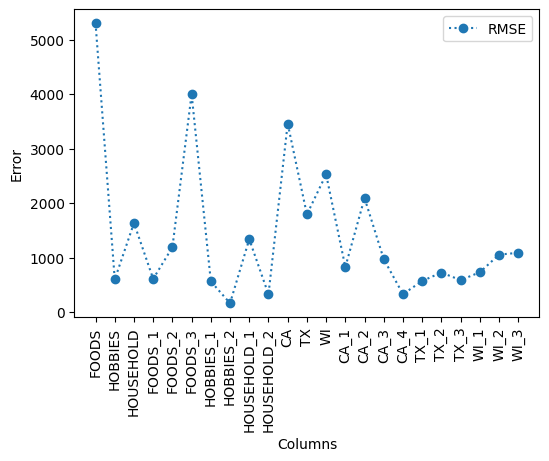

In [13]:
# Plot the RMSE values
plt.figure(figsize=(6,4))
plt.plot(target_columns, rmse_prophet, marker='o', linestyle='dotted', label='RMSE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

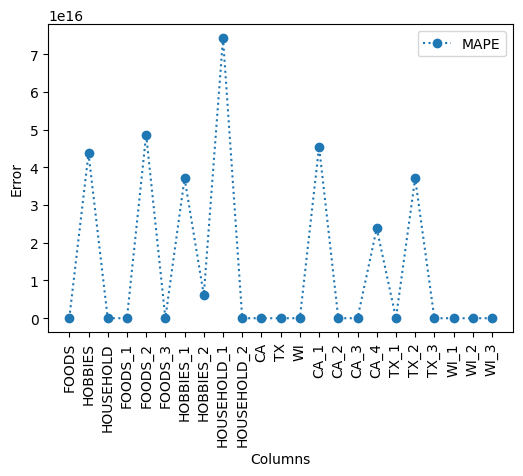

In [14]:
# Plot the MAPE values
plt.figure(figsize=(6, 4))
plt.plot(target_columns, mape_prophet, marker='o', linestyle='dotted', label='MAPE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

### LightGBM

In [15]:
# For LightGBM, we donot need column 'ds'.
df_lgbm = df.drop(columns = ['ds'])
df_lgbm.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038


In [16]:
#Create lag_cols, lag by timestep 1 and backfill with the next immediate values to match dimensions.
#Lagged columns are lagged features or features for the data frame. 

lag_cols = ['FOODS', 'HOBBIES', 'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3','HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'CA','TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1','WI_2', 'WI_3']
for col in lag_cols:
    df_lgbm[f'lag_1_{col}'] = df_lgbm[col].shift(1)

df_lgbm = df_lgbm.bfill()
df_lgbm.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,lag_1_CA_1,lag_1_CA_2,lag_1_CA_3,lag_1_CA_4,lag_1_TX_1,lag_1_TX_2,lag_1_TX_3,lag_1_WI_1,lag_1_WI_2,lag_1_WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,4337.0,3494.0,4739.0,1625.0,2556.0,3852.0,3030.0,2704.0,2256.0,4038.0


In [17]:
# Split the data into training and testing sets
train_size = int(len(df_lgbm) * 0.8)
train_data = df_lgbm[:train_size]
test_data = df_lgbm[train_size+1:]

# Now our target variables are the main data frame columns.
# We are labeling main target variables in dataframe as target variables if the difference in time by 1 step matches.

target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

feature_cols = [col for col in df_lgbm.columns if col not in target_cols]

train_dataset = lgb.Dataset(train_data[feature_cols], label=train_data[target_cols])
test_dataset = lgb.Dataset(test_data[feature_cols], label=test_data[target_cols])

In [18]:
# Since we have continous values, this problem is treated as regression. MSE is appropriate metric for regression. 
#`num_leaves --> represents the maximum number of leaves in a tree. A leaf is a node that does not have any child nodes. 
#A common practice is to set `num_leaves` to a value between 2^(max_depth) and 2^(max_depth+1)
# Maximum no. of levels is max_depth. Reduce no. of leaves for better accuracy.

params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': -1
}


In [19]:
models = {}  # Dictionary to store the trained models
rmse_lgbm = {}  # Dictionary to store the RMSE values
mape_lgbm = {} # Dictionary to store the MAPE values

# Train separate models for each target variable

start_time = time.time()

for target_col in target_cols:
    train_label = train_data[target_col]
    test_label = test_data[target_col]

    train_dataset = lgb.Dataset(train_data[feature_cols], label=train_label)
    test_dataset = lgb.Dataset(test_data[feature_cols], label=test_label)

    # Train the model
    model = lgb.train(params, train_dataset, num_boost_round=100)
    models[target_col] = model

    # Evaluate the model
    predictions_lgbm = model.predict(test_data[feature_cols])
    mse = np.mean((predictions_lgbm - test_label) ** 2)
    rmse = math.sqrt(mse)
    rmse_lgbm[target_col] = rmse
    mape = mean_absolute_percentage_error(predictions_lgbm, test_label)
    mape_lgbm[target_col] = mape
    
    print("RMSE for {}: {}".format(target_col, rmse))
    print("MAPE for {}: {}".format(target_col, mape))
    
execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 23018.371895
RMSE for FOODS: 3323.572590710736
MAPE for FOODS: 0.09103209396153308
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 3031.590196
RMSE for HOBBIES: 584.9666530532597
MAPE for HOBBIES: 0.11834419501970976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhe

In [20]:
predictions_lgbm = {}

for target_col in target_cols:
    model = models[target_col]
    
    # Get predictions for the target variable
    predictions_lgbm[target_col] = model.predict(test_data[feature_cols])
    
    # Print the predictions for the target variable
    print("Predictions for {}: {}".format(target_col, predictions_lgbm[target_col]))

Predictions for FOODS: [22617.57957559 22361.41136947 24526.30643063 27537.39640784
 28030.45097398 22300.42382139 26256.00225919 25076.63780814
 23661.07272899 24564.8733847  27228.44963341 25376.39050804
 20430.58119594 19912.16877069 20325.74442794 20214.30648848
 26499.86047442 29503.94269615 26942.42984041 22832.4090583
 18780.86229462 20278.05929566 19727.63260098 29116.27388114
 30338.07540538 29032.84145345 23031.68480782 23927.0138896
 23683.62075882 22149.7587471  28188.76904008 29012.51558846
 22675.73760582 23543.50182539 23293.93649883 23158.60182958
 23234.88916128 29063.581579   26596.66105599 28093.53012993
 22042.99446431 21272.66212727 20538.48704373 21497.65367075
 24155.73021129 26429.43693361 23892.17542548 23294.23564321
 19586.33203613 21261.85563714 20364.60545703 25159.0562035
 29088.51564609 24550.18261256 25132.36643547 25782.01111843
 25726.78403275 24976.58554371 27689.19290338 30178.46865337
 29676.39970186 26727.420726   25446.83092024 25794.14233314
 277

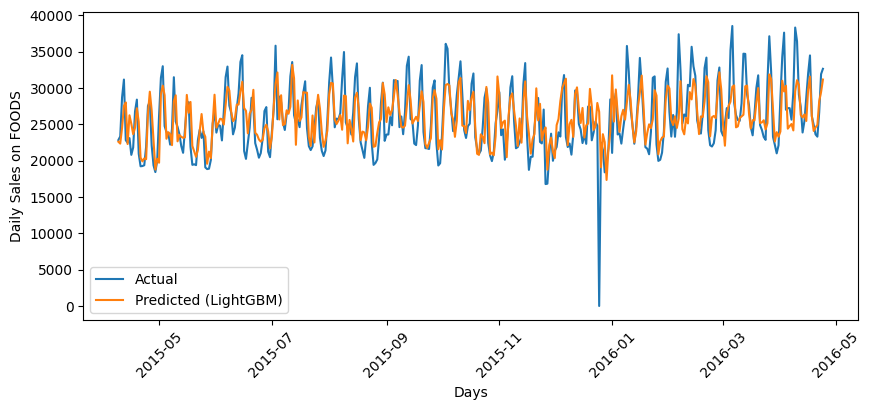

In [55]:
# Plot the predictions and test data
# Convert the index to a DatetimeIndex
test_data.index = pd.to_datetime(test_data.index)

plt.figure(figsize=(10, 4))
plt.plot(test_data.index, test_data['FOODS'], label='Actual')
plt.plot(test_data.index, predictions_lgbm['FOODS'], label='Predicted (LightGBM)')
plt.xlabel('Days')
plt.ylabel('Daily Sales on FOODS')
#plt.title('LightGBM FIT')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [22]:
print("All RMSE values:", rmse_lgbm, "\n""\n""All MAPE values:", mape_lgbm)

All RMSE values: {'FOODS': 3323.572590710736, 'HOBBIES': 584.9666530532597, 'HOUSEHOLD': 1556.9815601826692, 'FOODS_1': 433.580811885487, 'FOODS_2': 985.145058307548, 'FOODS_3': 2506.319096949099, 'HOBBIES_1': 546.4696275758293, 'HOBBIES_2': 74.11445759725457, 'HOUSEHOLD_1': 1270.9895115013646, 'HOUSEHOLD_2': 304.84942938691574, 'CA': 2524.9280791791202, 'TX': 1345.9826239889562, 'WI': 1989.1700887986544, 'CA_1': 711.5579674482576, 'CA_2': 1228.992715257973, 'CA_3': 795.5612385655091, 'CA_4': 267.6572116193387, 'TX_1': 452.17616746632797, 'TX_2': 595.6935014294424, 'TX_3': 508.4821113023423, 'WI_1': 742.418801286614, 'WI_2': 843.6342349679933, 'WI_3': 632.6615970831949} 

All MAPE values: {'FOODS': 0.09103209396153308, 'HOBBIES': 0.11834419501970976, 'HOUSEHOLD': 0.12334029634086478, 'FOODS_1': 0.10585752692541775, 'FOODS_2': 0.1526492489023425, 'FOODS_3': 0.10068463661244745, 'HOBBIES_1': 0.1250662873532851, 'HOBBIES_2': 0.15851564777142907, 'HOUSEHOLD_1': 0.12784034943337377, 'HOUSEH

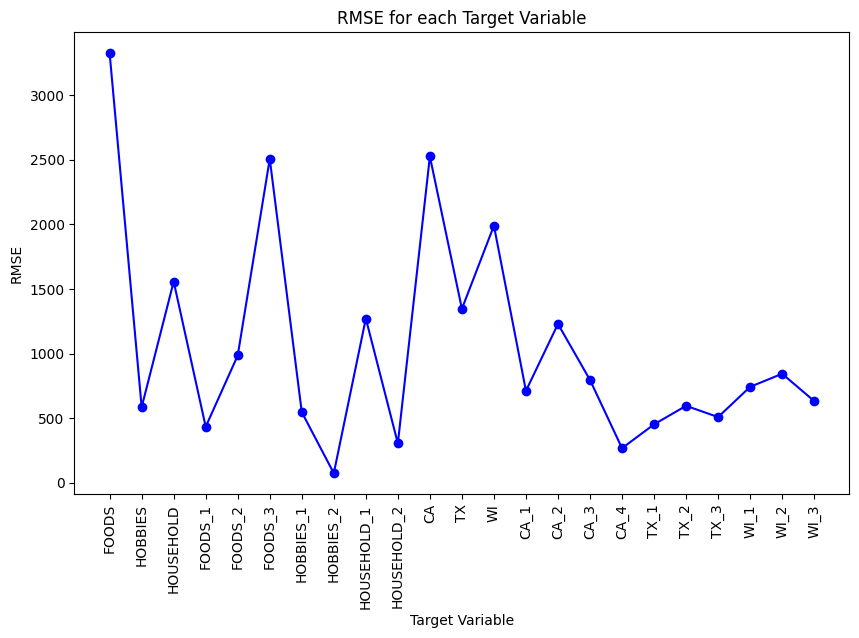

In [23]:
# Plot RMSE values against each target variable
plt.figure(figsize=(10, 6))
plt.plot(list(rmse_lgbm.keys()), list(rmse_lgbm.values()), marker='o', linestyle='-', color='blue')
plt.xlabel('Target Variable')
plt.ylabel('RMSE')
plt.title('RMSE for each Target Variable')
plt.xticks(rotation=90)
plt.show()

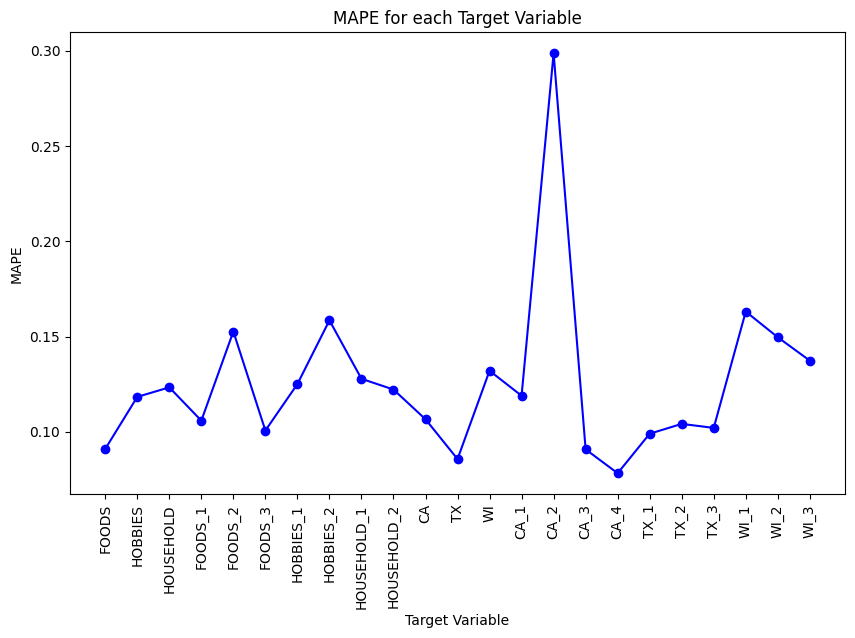

In [24]:
# Plot RMSE values against each target variable
plt.figure(figsize=(10, 6))
plt.plot(list(mape_lgbm.keys()), list(mape_lgbm.values()), marker='o', linestyle='-', color='blue')
plt.xlabel('Target Variable')
plt.ylabel('MAPE')
plt.title('MAPE for each Target Variable')
plt.xticks(rotation=90)
plt.show()

### ARIMA model (SARIMA)

In [25]:
#Create data frame for ARIMA:
df_arima = df.copy()

# train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
# Split the data into train and test sets
train_size = int(len(df_arima) * 0.8)  # 80% for training
train, test = df_arima[:train_size], df_arima[train_size+1:]

In [26]:
target_columns = ['FOODS', 'HOBBIES', 'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3','HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'CA','TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1','WI_2', 'WI_3']

results = {}

# Start measuring execution time
start_time = time.time()

for column in target_columns:
    train_target = train[column]
    model = pm.auto_arima(train_target, seasonal=True, m=12, suppress_warnings=True)

    p, d, q = model.order
    P, D, Q, m = model.seasonal_order

    # Print the estimated parameters
    print(f"Estimated parameters for {column}: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, m={m}")
    
    forecast = model.predict(n_periods=len(test))
    rmse = np.sqrt(mean_squared_error(test[column], forecast))
    mape = mean_absolute_percentage_error(test[column], forecast)
    
    #results dictionary will store all values.
    
    results[column] = {'order': model.order, 'seasonal_order': model.seasonal_order, 'RMSE': rmse, 'MAPE': mape}
    
# Calculate the execution time
execution_time = time.time() - start_time

# Print the execution time
print(f"Execution time: {execution_time} seconds")

Estimated parameters for FOODS: p=5, d=1, q=5, P=0, D=0, Q=1, m=12
Estimated parameters for HOBBIES: p=4, d=1, q=3, P=0, D=0, Q=2, m=12
Estimated parameters for HOUSEHOLD: p=5, d=1, q=5, P=1, D=0, Q=0, m=12
Estimated parameters for FOODS_1: p=5, d=1, q=2, P=1, D=0, Q=0, m=12
Estimated parameters for FOODS_2: p=5, d=1, q=4, P=2, D=0, Q=1, m=12
Estimated parameters for FOODS_3: p=5, d=1, q=4, P=0, D=0, Q=1, m=12
Estimated parameters for HOBBIES_1: p=4, d=1, q=3, P=1, D=0, Q=0, m=12
Estimated parameters for HOBBIES_2: p=0, d=1, q=2, P=0, D=0, Q=1, m=12
Estimated parameters for HOUSEHOLD_1: p=5, d=1, q=5, P=0, D=0, Q=0, m=12
Estimated parameters for HOUSEHOLD_2: p=5, d=1, q=2, P=0, D=0, Q=0, m=12
Estimated parameters for CA: p=5, d=1, q=2, P=1, D=0, Q=0, m=12
Estimated parameters for TX: p=3, d=1, q=3, P=1, D=0, Q=1, m=12
Estimated parameters for WI: p=0, d=1, q=3, P=1, D=0, Q=2, m=12
Estimated parameters for CA_1: p=5, d=1, q=2, P=1, D=0, Q=0, m=12
Estimated parameters for CA_2: p=2, d=1,

In [27]:
# Fit ARIMA 
model = ARIMA(test['FOODS'], order=(5,1,5), seasonal_order=(2,0,1,12))
model_fit = model.fit()

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
# Generate predictions using the fitted model
predictions_arima = model_fit.predict(start=1, end=len(test['FOODS']), typ='levels')
predictions_arima

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2015-04-10    20431.346314
2015-04-11    18686.201639
2015-04-12    25038.171626
2015-04-13    24925.326283
2015-04-14    16164.378220
                  ...     
2016-04-21    23664.936823
2016-04-22    26671.179605
2016-04-23    32677.091929
2016-04-24    32245.118451
2016-04-25    27396.758605
Freq: D, Name: predicted_mean, Length: 382, dtype: float64

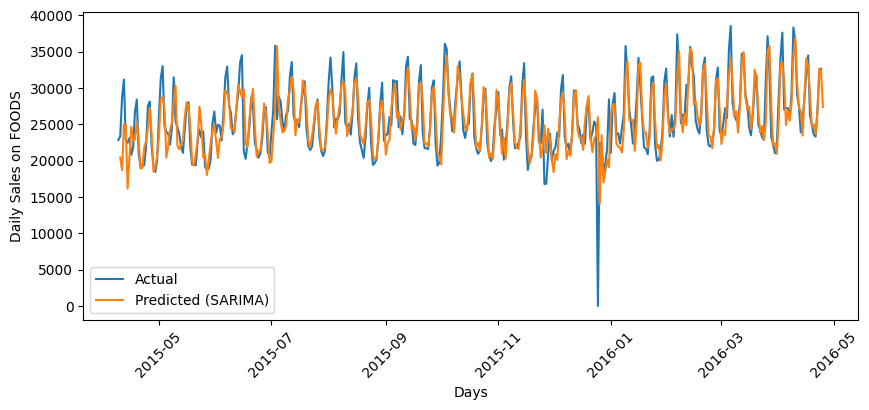

In [53]:
# Convert the index to a DatetimeIndex
test.index = pd.to_datetime(test.index)
plt.figure(figsize=(10, 4))

# Plot the actual and predicted values for the "FOODS" category
plt.plot(test['FOODS'], label='Actual')
plt.plot(predictions_arima, label='Predicted (SARIMA)')
plt.xlabel('Days')
plt.ylabel('Daily Sales on FOODS')
#plt.title('ARIMA FIT')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [30]:
rmse_values = []
mape_values = []
target_variables = []

for column, result in results.items():
    target_variables.append(column)
    rmse_values.append(result['RMSE'])
    mape_values.append(result['MAPE'])

print("Target Variables:", target_variables, "\n","\n", "RMSE Values:", rmse_values, "\n", "\n","MAPE Values:", mape_values)

Target Variables: ['FOODS', 'HOBBIES', 'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'CA', 'TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'] 
 
 RMSE Values: [4236.316723918323, 722.9587804912617, 1744.563933804136, 501.8643498636273, 1052.8060754643564, 3019.485625175322, 564.1090882968341, 107.71514370490577, 1457.2227059488523, 311.7684220978746, 2845.070878093155, 2452.900482994489, 2568.1895181351188, 675.2928099681411, 1690.6794693220677, 1252.527860456889, 306.3509659901929, 641.2702711133608, 567.048465141332, 1095.8547022419095, 667.7591649917505, 1094.4614910282958, 853.7038135087865] 
 
 MAPE Values: [4.8268882257642405, 5.049101107438207e+16, 21.110534498591498, 7.831990981790726, 5.441585862127289e+16, 3.6113802456763096, 4.2801511814373736e+16, 4706108864545185.0, 7.42765356234394e+16, 4.985145716817692, 6.609542982197694, 8.242023291222536, 6.97018575070747, 5.13285739194488

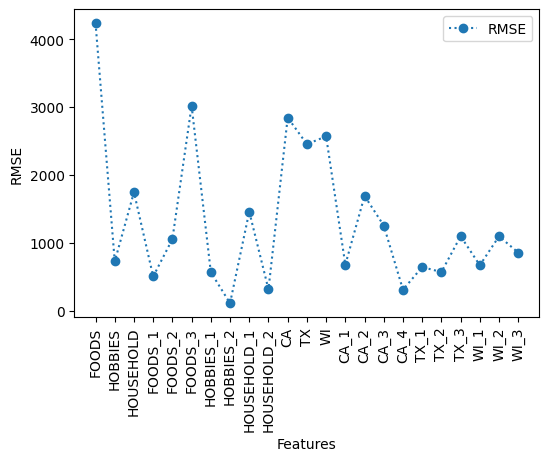

In [31]:
# Plot the RMSE values
plt.figure(figsize=(6,4))
plt.plot(target_variables, rmse_values, marker='o', linestyle='dotted', label='RMSE')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('RMSE')
plt.legend()
plt.show()

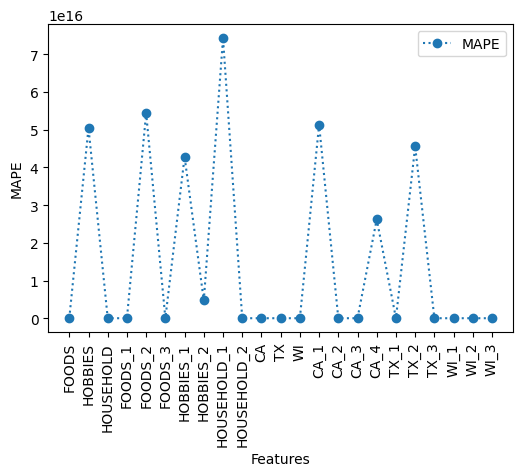

In [32]:
# Plot the MAPE values
plt.figure(figsize=(6,4))
plt.plot(target_variables, mape_values, marker='o', linestyle='dotted',label='MAPE')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('MAPE')
#plt.title('MAPE')
plt.legend()
plt.show()

### RMSE plots

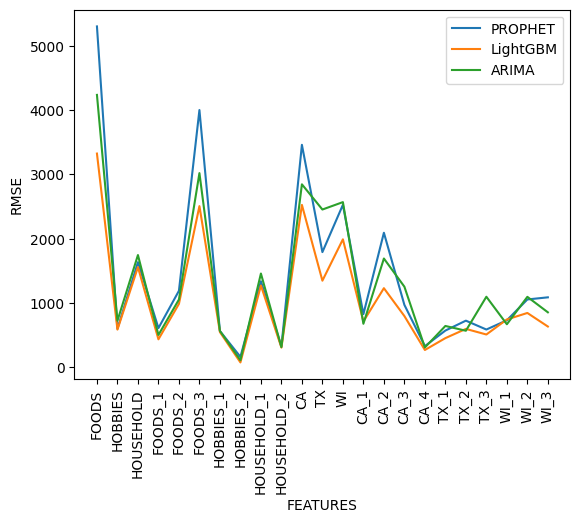

In [60]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']

prophet_rmse = [5301.623329719902, 597.4043395495909, 1633.8766240582363, 608.0407142987697, 1188.3787984445187, 4000.841626437104, 562.1306982570026, 161.21043116892037, 1336.4195793128986, 323.5977981894443, 3459.4404039642304, 1790.5406370880542, 2526.2609502754617, 824.9772115486344, 2091.3778069266905, 969.4602774964568, 327.46010935947385, 569.8731930316046, 723.8847384406837, 585.7749971912388, 729.6913761833301, 1053.577187093273, 1086.7709855259027]
lgbm_rmse = [3323.572590710736, 584.9666530532597, 1556.9815601826692, 433.580811885487, 985.145058307548, 2506.319096949099, 546.4696275758293, 74.11445759725457,1270.9895115013646, 304.84942938691574, 2524.9280791791202, 1345.9826239889562, 1989.1700887986544, 711.5579674482576, 1228.992715257973, 795.5612385655091, 267.6572116193387, 452.17616746632797, 595.6935014294424, 508.4821113023423, 742.418801286614, 843.6342349679933, 632.6615970831949]
arima_rmse = [4236.316723918323, 722.9587804912617, 1744.563933804136, 501.8643498636273, 1052.8060754643564, 3019.485625175322, 564.1090882968341, 107.71514370490577, 1457.2227059488523, 311.7684220978746, 2845.070878093155, 2452.900482994489, 2568.1895181351188, 675.2928099681411, 1690.6794693220677, 1252.527860456889, 306.3509659901929, 641.2702711133608, 567.048465141332, 1095.8547022419095, 667.7591649917505, 1094.4614910282958, 853.7038135087865] 

plt.plot(target_cols, prophet_rmse, label="PROPHET")
plt.plot(target_cols, lgbm_rmse, label="LightGBM")
plt.plot(target_cols, arima_rmse, label="ARIMA")
plt.xlabel("FEATURES")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### MAPE plots

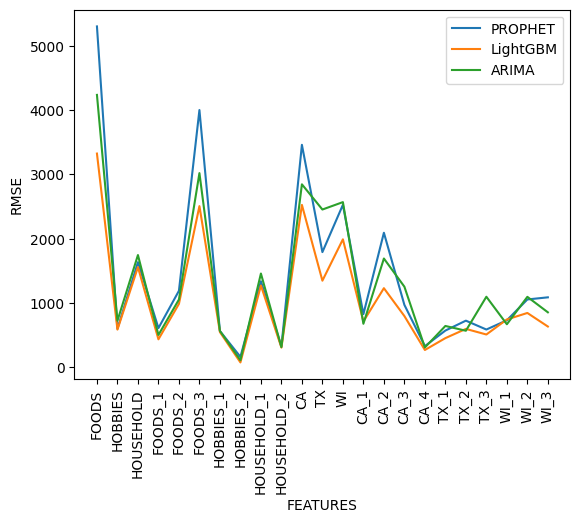

In [61]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3'] 
prophet_mape = [4.2924385926396615, 4.3668410261305784e+16, 20.811984825352617, 8.016773481374887, 4.864900488117681e+16, 3.057471387046034, 3.710896775023157e+16, 6150141164100668.0, 7.421872919005626e+16, 4.331195138915735, 5.649445254110273, 6.1533256942561145, 6.47695216426565, 4.5481428789541704e+16, 2.425962623395828, 3.493233994656482, 2.3840233321259836e+16, 7.472485534277767, 3.70919010331124e+16, 3.0198442640152927, 4.896939838162112, 10.061242287010963, 6.507056662836419]
lgbm_mape = [0.09103209396153308,0.11834419501970976, 0.12334029634086478, 0.10585752692541775, 0.1526492489023425, 0.10068463661244745, 0.1250662873532851,0.15851564777142907,0.12784034943337377, 0.12220433124696857, 0.10660274724359552, 0.0856975029548464, 0.13205575167781078,0.11893808321323282, 0.29872346641541914, 0.09078957270617109, 0.07827491405723837, 0.09900575265306356, 0.10417071978561113, 0.10206807502411998, 0.16312508129842623, 0.14963717949499108, 0.13737085799497573]
arima_mape = [4.8268882257642405, 5.049101107438207e+16, 21.110534498591498, 7.831990981790726, 5.441585862127289e+16, 3.6113802456763096, 4.2801511814373736e+16, 4706108864545185.0, 7.42765356234394e+16, 4.985145716817692, 6.609542982197694, 8.242023291222536, 6.97018575070747, 5.132857391944886e+16, 3.172299356970989, 4.314913006676469, 2.624066509289834e+16, 9.144338012912467, 4.556946421272187e+16, 4.282503662091678, 4.863747403292108, 10.253098608428328, 8.219723925216618]

plt.plot(target_cols, prophet_rmse, label="PROPHET")
plt.plot(target_cols, lgbm_rmse, label="LightGBM")
plt.plot(target_cols, arima_rmse, label="ARIMA")
plt.xlabel("FEATURES")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### Both errors suggest LightGBM is the best model

### Ensemble of PROPHET and LGBM

In [36]:
#Let us convert it to a Pandas series for ensembling methods. 
predictions_prophet_series = pd.Series(predictions_prophet)

# Convert predictions_lgbm to pandas Series for ensemblin methods.
predictions_lgbm_series = pd.Series(predictions_lgbm)

In [37]:
# Combine Prophet and LightGBM predictions using simple averaging
prophet_lgbm_ensemble = (predictions_prophet_series +  predictions_lgbm_series) / 2

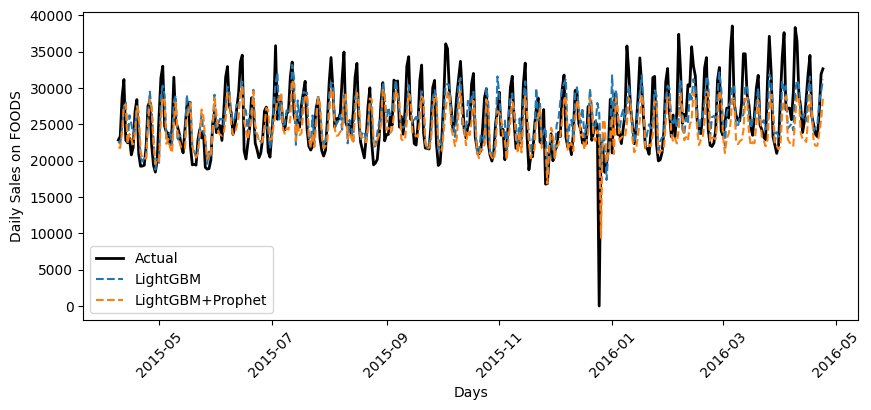

In [56]:
# Convert the index to a DatetimeIndex
test.index = pd.to_datetime(test.index)
plt.figure(figsize=(10, 4))

# Plot the actual and predicted values for the "FOODS" category
plt.plot(test['FOODS'], linewidth = 2, color ='black', label='Actual')
plt.plot(test_data.index, predictions_lgbm['FOODS'], '--',label='LightGBM')
plt.plot(test_data.index,prophet_lgbm_ensemble['FOODS'],'--',label='LightGBM+Prophet')

plt.xlabel('Days')
plt.ylabel('Daily Sales on FOODS')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [43]:
#MAPE and RMSE calculations for ensembling method.
mape_ensemble = []
rmse_ensemble = []

for column in target_columns:
    actual = test[column].values.astype('float64')
    predicted_ensemble = prophet_lgbm_ensemble[column].values
    
    # Convert actual and predicted_ensemble to numpy arrays because actual is a dataframe and the other is not.
    actual = actual.flatten()
    predicted_ensemble = predicted_ensemble.flatten()
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted_ensemble)
    mape_ensemble.append(mape)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted_ensemble))
    rmse_ensemble.append(rmse)

print("RMSE_Ensemble:", rmse_ensemble)
print("MAPE_Ensemble:", mape_ensemble)

RMSE_Ensemble: [3903.7719091744016, 519.5933073273346, 1460.3508073469993, 483.75060574758936, 1047.733539413832, 2874.229848387095, 501.4032144487473, 90.4238885970287, 1197.589539083497, 286.228763880956, 2820.348623518936, 1439.313566672941, 2153.2572537138944, 704.0581955696836, 1618.5803150047554, 822.0731837423892, 284.0825137130968, 469.2986803042204, 572.7429731188919, 514.3214048077276, 663.8648454291134, 911.4689604251598, 794.2919623574052]
MAPE_Ensemble: [4.86532504497769, 4.3979670881956056e+16, 24.07955122469869, 8.4452604408742, 5.283997965266601e+16, 3.609294910290642, 3.892023017524073e+16, 5066474425129882.0, 8.715524046896475e+16, 4.855332290438401, 6.544323117051331, 6.923594741515039, 7.209145769986223, 4.986523508211621e+16, 3.732175510893986, 3.9034571841175083, 2.5753010512545524e+16, 8.335571738552513, 4.761724886885661e+16, 3.1870117926455968, 4.999871879518228, 10.396324497185612, 8.92567464539181]


###  RMSE Plot (including Ensembling)

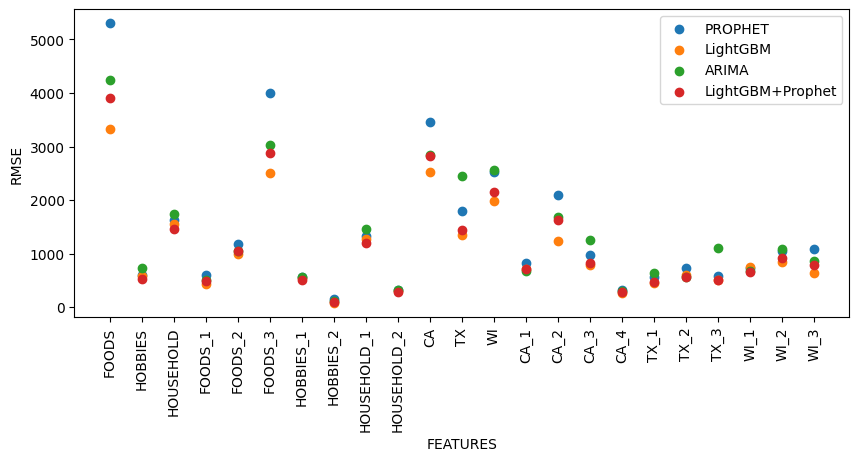

In [62]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']

prophet_rmse = [5301.623329719902, 597.4043395495909, 1633.8766240582363, 608.0407142987697, 1188.3787984445187, 4000.841626437104, 562.1306982570026, 161.21043116892037, 1336.4195793128986, 323.5977981894443, 3459.4404039642304, 1790.5406370880542, 2526.2609502754617, 824.9772115486344, 2091.3778069266905, 969.4602774964568, 327.46010935947385, 569.8731930316046, 723.8847384406837, 585.7749971912388, 729.6913761833301, 1053.577187093273, 1086.7709855259027]
lgbm_rmse = [3323.572590710736, 584.9666530532597, 1556.9815601826692, 433.580811885487, 985.145058307548, 2506.319096949099, 546.4696275758293, 74.11445759725457,1270.9895115013646, 304.84942938691574, 2524.9280791791202, 1345.9826239889562, 1989.1700887986544, 711.5579674482576, 1228.992715257973, 795.5612385655091, 267.6572116193387, 452.17616746632797, 595.6935014294424, 508.4821113023423, 742.418801286614, 843.6342349679933, 632.6615970831949]
arima_rmse = [4236.316723918323, 722.9587804912617, 1744.563933804136, 501.8643498636273, 1052.8060754643564, 3019.485625175322, 564.1090882968341, 107.71514370490577, 1457.2227059488523, 311.7684220978746, 2845.070878093155, 2452.900482994489, 2568.1895181351188, 675.2928099681411, 1690.6794693220677, 1252.527860456889, 306.3509659901929, 641.2702711133608, 567.048465141332, 1095.8547022419095, 667.7591649917505, 1094.4614910282958, 853.7038135087865] 
lgbm_prophet_rmse = [3903.7719091744016, 519.5933073273346, 1460.3508073469993, 483.7506057475894, 1047.733539413832, 2874.229848387095, 501.4032144487473, 90.4238885970287, 1197.589539083497, 286.228763880956, 2820.348623518936, 1439.313566672941, 2153.2572537138944, 704.0581955696836, 1618.5803150047554, 822.0731837423892, 284.08251371309683, 469.2986803042204, 572.7429731188919, 514.3214048077276, 663.8648454291134, 911.4689604251598, 794.2919623574052]

plt.figure(figsize=(10, 4))
plt.scatter(target_cols, prophet_rmse, label="PROPHET")
plt.scatter(target_cols, lgbm_rmse, label="LightGBM")
plt.scatter(target_cols, arima_rmse, label="ARIMA")
plt.scatter(target_cols, lgbm_prophet_rmse, label="LightGBM+Prophet")

plt.xlabel("FEATURES")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### MAPE Plot (including Ensembling) 

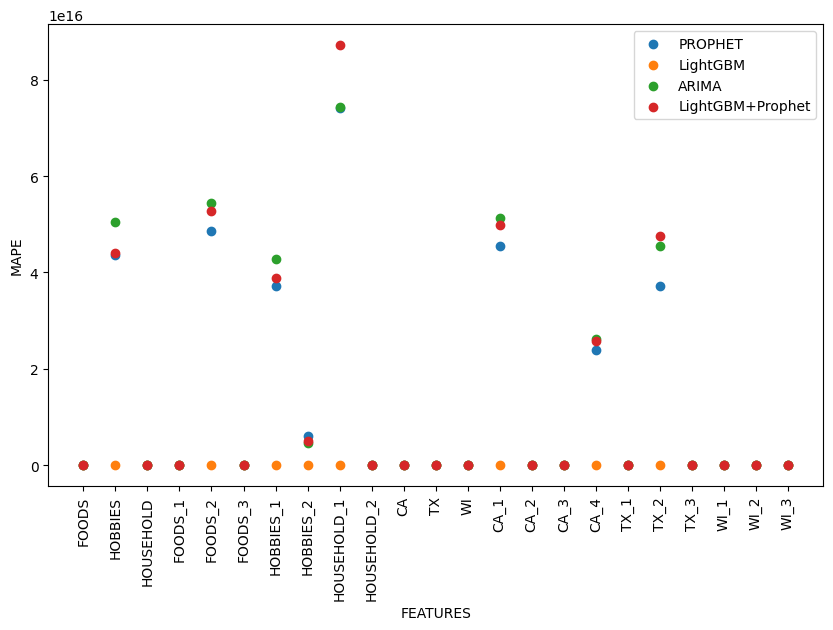

In [63]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3'] 
prophet_mape = [4.2924385926396615, 4.3668410261305784e+16, 20.811984825352617, 8.016773481374887, 4.864900488117681e+16, 3.057471387046034, 3.710896775023157e+16, 6150141164100668.0, 7.421872919005626e+16, 4.331195138915735, 5.649445254110273, 6.1533256942561145, 6.47695216426565, 4.5481428789541704e+16, 2.425962623395828, 3.493233994656482, 2.3840233321259836e+16, 7.472485534277767, 3.70919010331124e+16, 3.0198442640152927, 4.896939838162112, 10.061242287010963, 6.507056662836419]
lgbm_mape = [0.09103209396153308,0.11834419501970976, 0.12334029634086478, 0.10585752692541775, 0.1526492489023425, 0.10068463661244745, 0.1250662873532851,0.15851564777142907,0.12784034943337377, 0.12220433124696857, 0.10660274724359552, 0.0856975029548464, 0.13205575167781078,0.11893808321323282, 0.29872346641541914, 0.09078957270617109, 0.07827491405723837, 0.09900575265306356, 0.10417071978561113, 0.10206807502411998, 0.16312508129842623, 0.14963717949499108, 0.13737085799497573]
arima_mape = [4.8268882257642405, 5.049101107438207e+16, 21.110534498591498, 7.831990981790726, 5.441585862127289e+16, 3.6113802456763096, 4.2801511814373736e+16, 4706108864545185.0, 7.42765356234394e+16, 4.985145716817692, 6.609542982197694, 8.242023291222536, 6.97018575070747, 5.132857391944886e+16, 3.172299356970989, 4.314913006676469, 2.624066509289834e+16, 9.144338012912467, 4.556946421272187e+16, 4.282503662091678, 4.863747403292108, 10.253098608428328, 8.219723925216618]
lgbm_prophet_mape = [4.86532504497769, 4.3979670881956056e+16, 24.07955122469869, 8.4452604408742, 5.283997965266601e+16, 3.609294910290642, 3.892023017524073e+16, 5066474425129882.0, 8.715524046896475e+16, 4.855332290438401, 6.544323117051331, 6.923594741515039, 7.209145769986223, 4.986523508211621e+16, 3.732175510893986, 3.9034571841175083, 2.5753010512545524e+16, 8.335571738552513, 4.761724886885661e+16, 3.1870117926455968, 4.999871879518228, 10.396324497185612, 8.92567464539181]

plt.figure(figsize=(10, 6))
plt.scatter(target_cols, prophet_mape, label="PROPHET")
plt.scatter(target_cols, lgbm_mape, label="LightGBM")
plt.scatter(target_cols, arima_mape, label="ARIMA")
plt.scatter(target_cols, lgbm_prophet_mape, label="LightGBM+Prophet")

plt.xlabel("FEATURES")
plt.ylabel("MAPE")
plt.legend()
plt.xticks(rotation = 90)
plt.show()